BOX 1: reading packages

In [167]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, chisquare
import statsmodels.formula.api as sfm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

BOX 2 reading the csv + checking each column for null values

In [145]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 6 duplicates

In [ ]:
duplicates = df[df.duplicated(subset='course_id')]
print(f"Number of duplicates found: {len(duplicates)}")

df.drop_duplicates(subset='course_id', keep='first', inplace=True)

print(f"Row count after removing duplicates: {len(df)}")

df.to_csv('udemy_database.csv', index=False)
print("Duplicates removed, and original CSV updated.")

Number of duplicates found: 0
Row count after removing duplicates: 3672
Duplicates removed, and original CSV updated.


BOX 4: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [ ]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


In [ ]:
mean = df["content_duration"].mean()
std_dev = df["content_duration"].std()

outliers = df[(df["content_duration"] < (mean - 3 * std_dev)) | (df["content_duration"] > (mean + 3 * std_dev))]

outliers.to_csv('outliers_content_duration.csv', index=False)

print("Outliers saved to 'outliers.csv'.")


Outliers saved to 'outliers.csv'.


BOX 4: the outliers intersection based on numeric variables

In [149]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



Common outliers for course_id & price: 0

Common outliers for course_id & num_subscribers: 0

Common outliers for course_id & num_reviews: 0

Common outliers for course_id & num_lectures: 0

Common outliers for course_id & content_duration: 0

Common outliers for price & num_subscribers: 0

Common outliers for price & num_reviews: 0

Common outliers for price & num_lectures: 0

Common outliers for price & content_duration: 0

Common outliers for num_subscribers & num_reviews: 20
  - Course ID 764164
  - Course ID 364426
  - Course ID 130064
  - Course ID 519442
  - Course ID 437398
  - Course ID 719002
  - Course ID 405926
  - Course ID 625204
  - Course ID 756150
  - Course ID 446134
  - Course ID 473160
  - Course ID 48841
  - Course ID 289230
  - Course ID 41295
  - Course ID 238934
  - Course ID 314462
  - Course ID 461160
  - Course ID 173548
  - Course ID 705264
  - Course ID 707962

Common outliers for num_subscribers & num_lectures: 10
  - Course ID 764164
  - Course ID 11174
 

BOX 6: plotting the data to better see the outliers

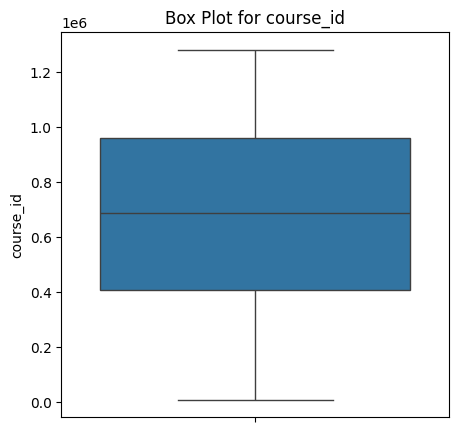

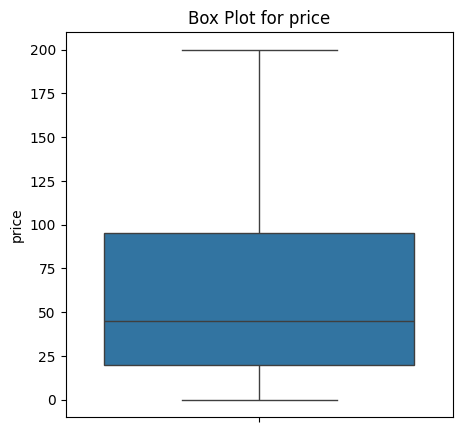

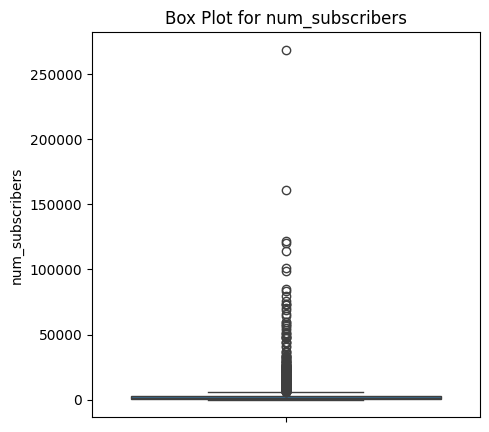

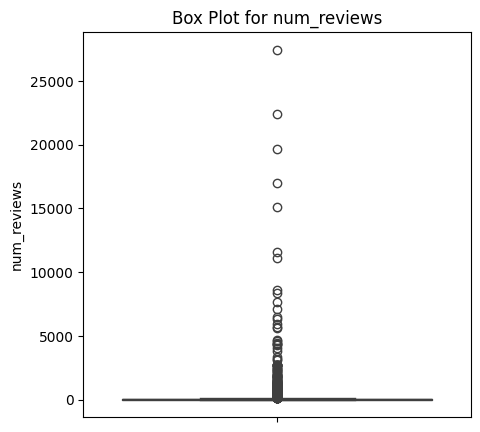

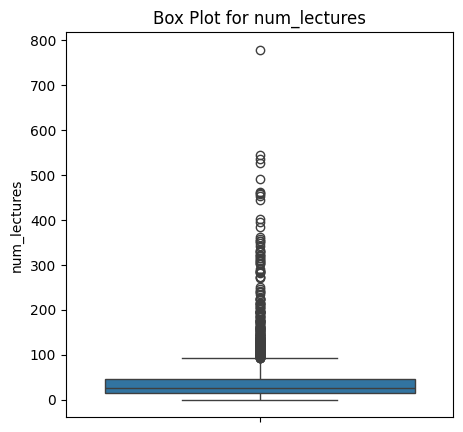

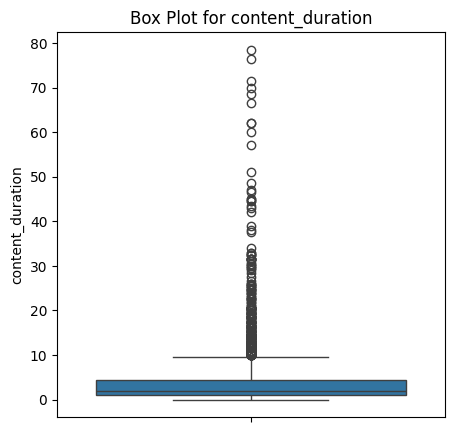

In [150]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=df[column])  
    plt.title(f'Box Plot for {column}')
    plt.ylabel(column)
    plt.show()

In [ ]:
df_outliers_num_subs = pd.read_csv('outliers_num_subscribers.csv')
outliers_num_subs = df_outliers_num_subs[(df_outliers_num_subs["subject"]) != "Web Development"]
print(outliers_num_subs["course_id"].count())

df_outliers_content_duration = pd.read_csv('outliers_content_duration.csv')
noutliers_content_duration = df_outliers_content_duration[(df_outliers_content_duration["content_duration"]) >= 40]
print(noutliers_content_duration["course_id"].count())

df_outliers_num_lectures= pd.read_csv('outliers_num_lectures.csv')	
outliers_num_lectures = df_outliers_num_lectures[(df_outliers_num_lectures["num_lectures"]) >= 400]
print(outliers_num_lectures["course_id"].count())

df_outliers_num_reviews = pd.read_csv('outliers_num_reviews.csv')
outliers_num_reviews = df_outliers_num_reviews[
    (df_outliers_num_reviews["num_reviews"] >= 10000) | (df_outliers_num_reviews["subject"] != "Web Development")]
print(outliers_num_reviews["course_id"].count())



# Concatenate all outliers and drop duplicates
all_outliers = pd.concat([outliers_num_subs, noutliers_content_duration, outliers_num_lectures, outliers_num_reviews]).drop_duplicates(subset="course_id")
print(all_outliers["course_id"].count())
# Check how many outliers are being identified
print("Number of unique outliers identified:", len(all_outliers["course_id"].unique()))

# Check if the outliers match the expected number of rows to be removed
print("Total number of rows before removing outliers:", len(df))
print("Number of rows to remove:", len(all_outliers))

# Remove outliers from df
df_no_outliers_udemy = df[~df["course_id"].isin(all_outliers["course_id"])]
print("Number of rows after removing outliers:", len(df_no_outliers_udemy))






12
21
11
9
42
Number of unique outliers identified: 42
Total number of rows before removing outliers: 3672
Number of rows to remove: 42
Number of rows after removing outliers: 3630


BOX 7 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [152]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

In [153]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")
    # print(outliers, "\n")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


Histogram with outliers

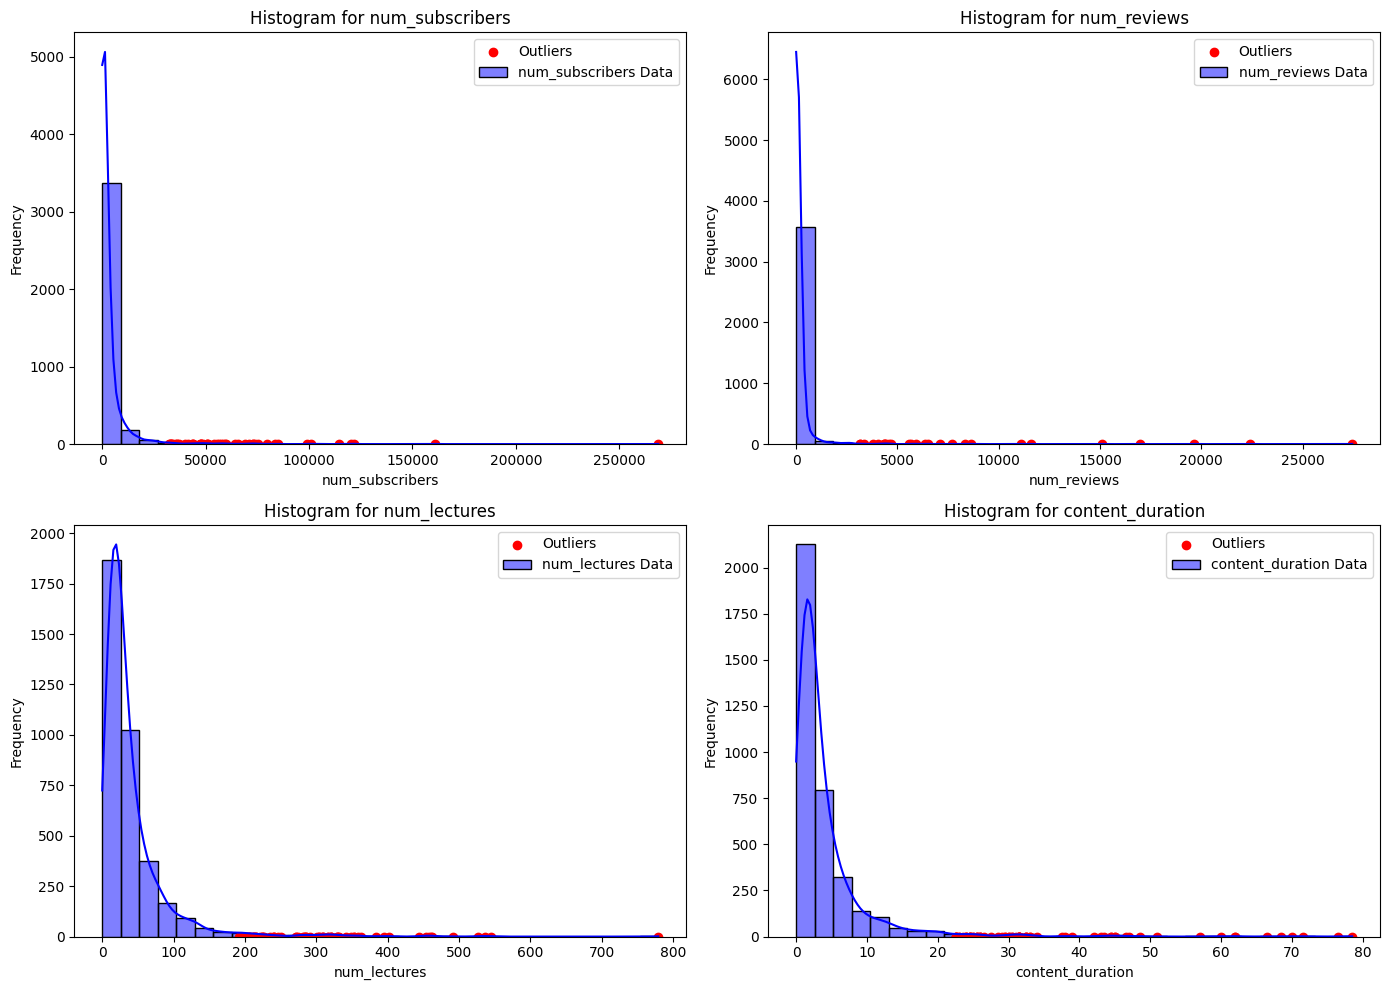

In [154]:
# List of independent variables to plot
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Set up the plot size
plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  # Create subplots in a 2x2 grid

    # Plot the histogram for the current variable
    sns.histplot(df[var], kde=True, color='blue', label=f'{var} Data', bins=30)

    # Highlight outliers (we assume outliers are already detected and stored in a variable like 'outliers_z_score')
    z_scores = np.abs((df[var] - df[var].mean()) / df[var].std())  # Z-score for current variable
    outliers_z_score = df[z_scores > 3]

    # Plot outliers in red on the histogram
    plt.scatter(outliers_z_score[var], np.zeros_like(outliers_z_score[var]), color='red', label='Outliers')

    # Add titles and labels
    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  # Adjust the layout to fit all subplots
plt.show()


    


Histogram for all independent variables without outliers

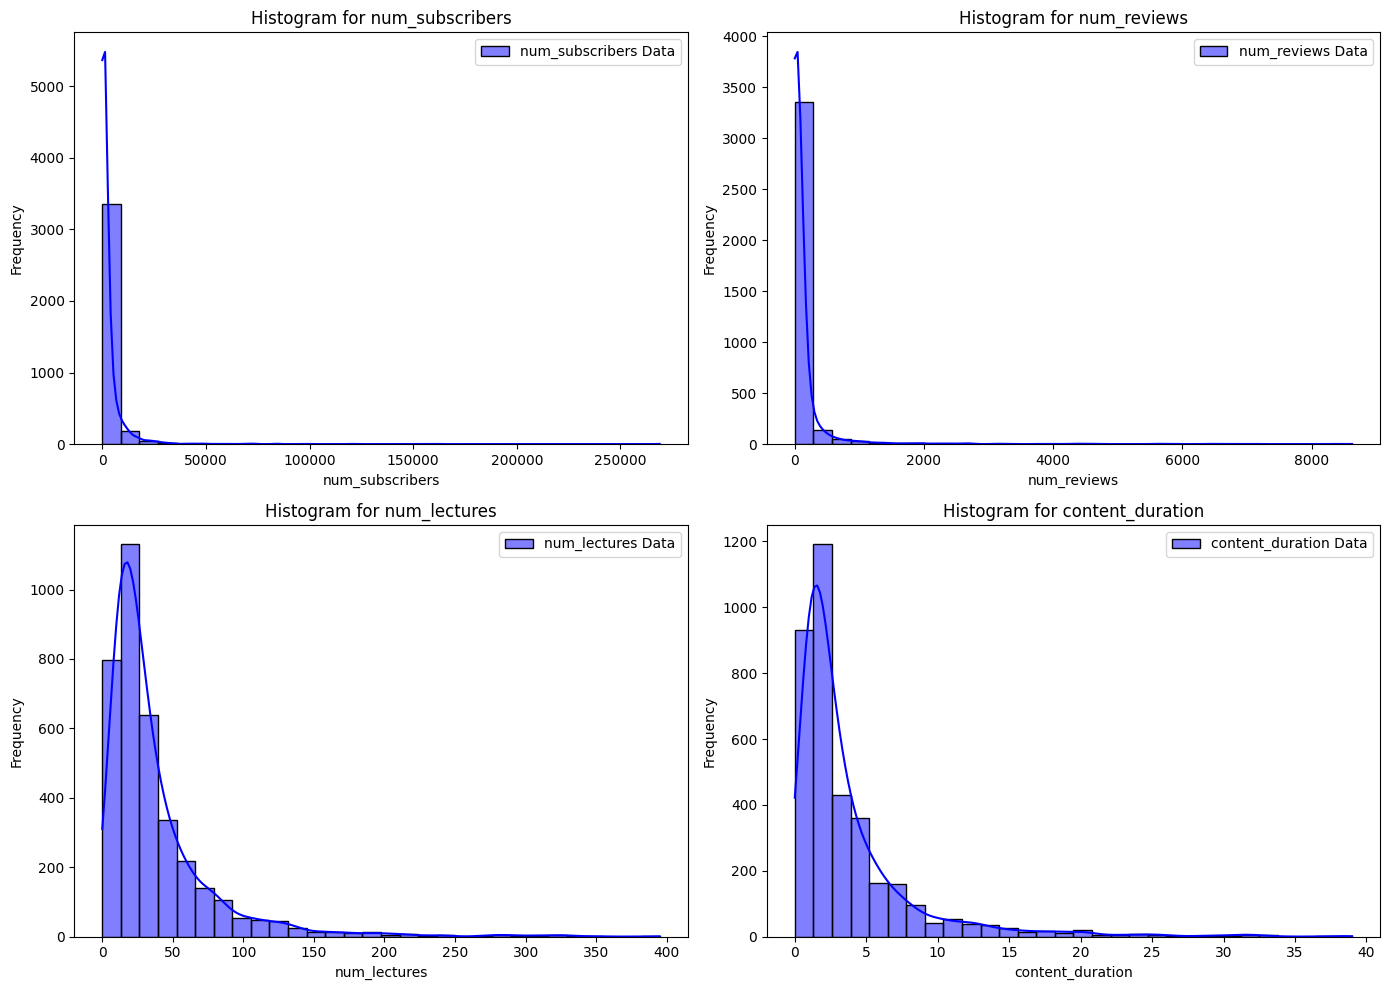

In [ ]:
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  


    sns.histplot(df_no_outliers_udemy[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


    


Histogram only for web dev courses without outliers

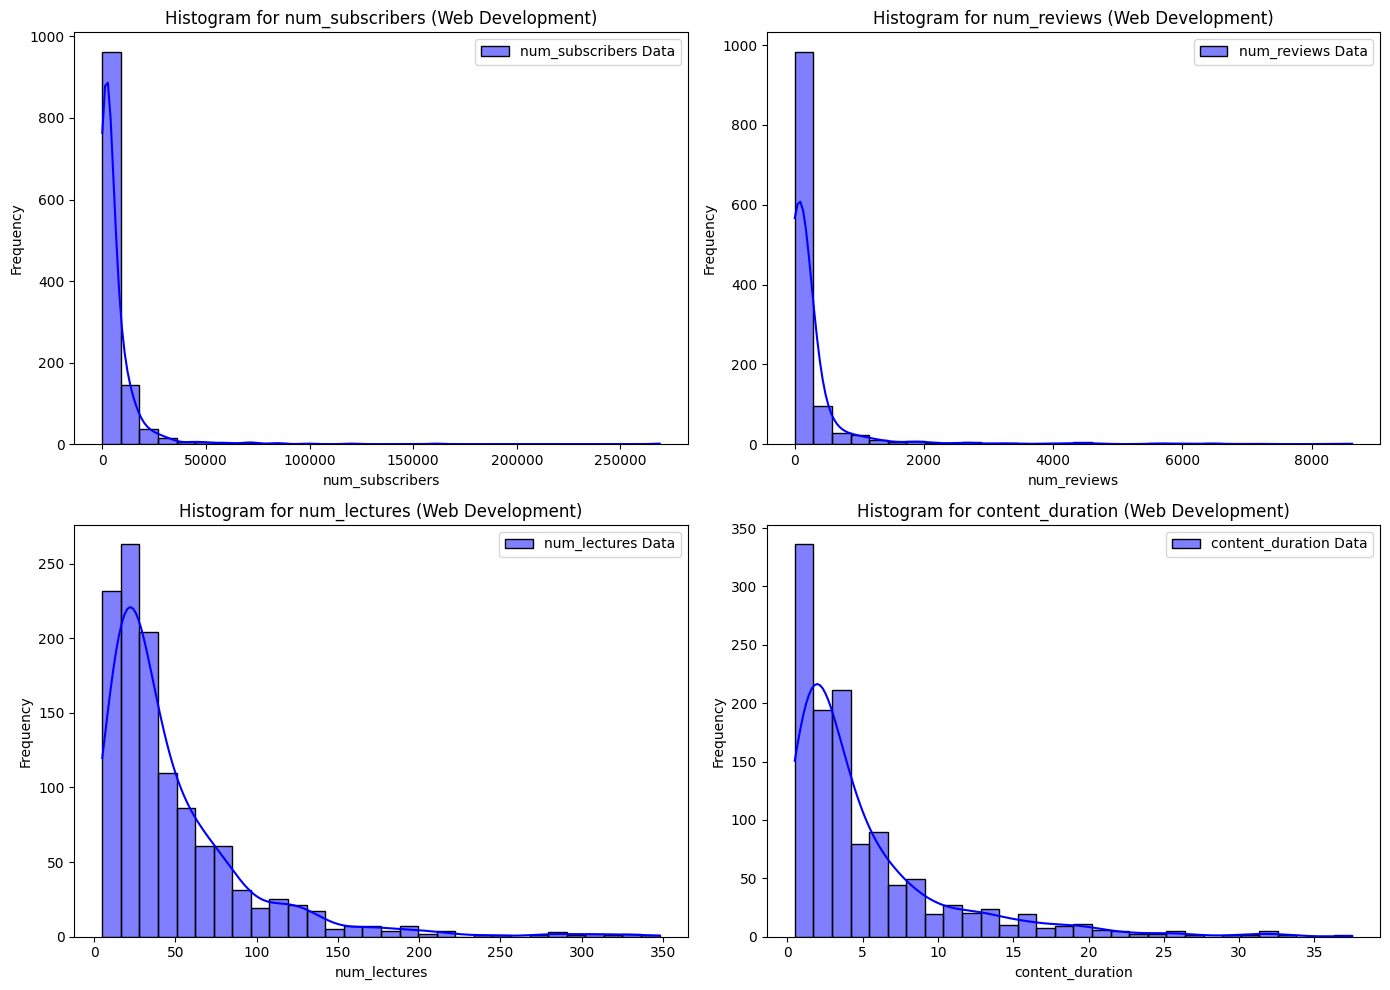

In [168]:
# Filter data for Web Development courses
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  

    # Create histogram for Web Development courses only
    sns.histplot(web_dev_courses[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var} (Web Development)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


histogram for web dev courses without outliers by levels

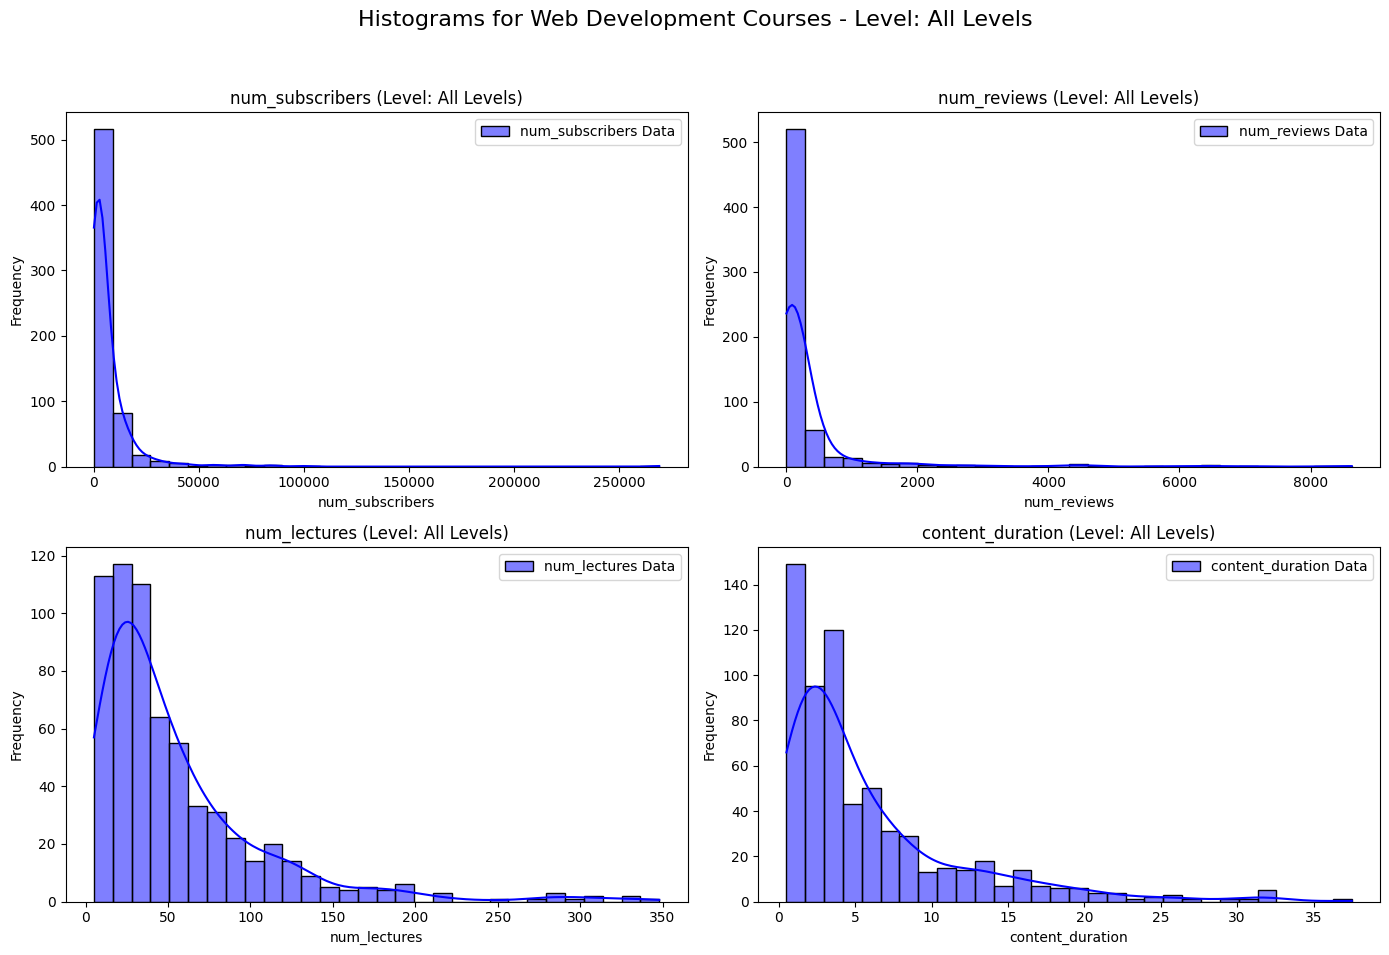

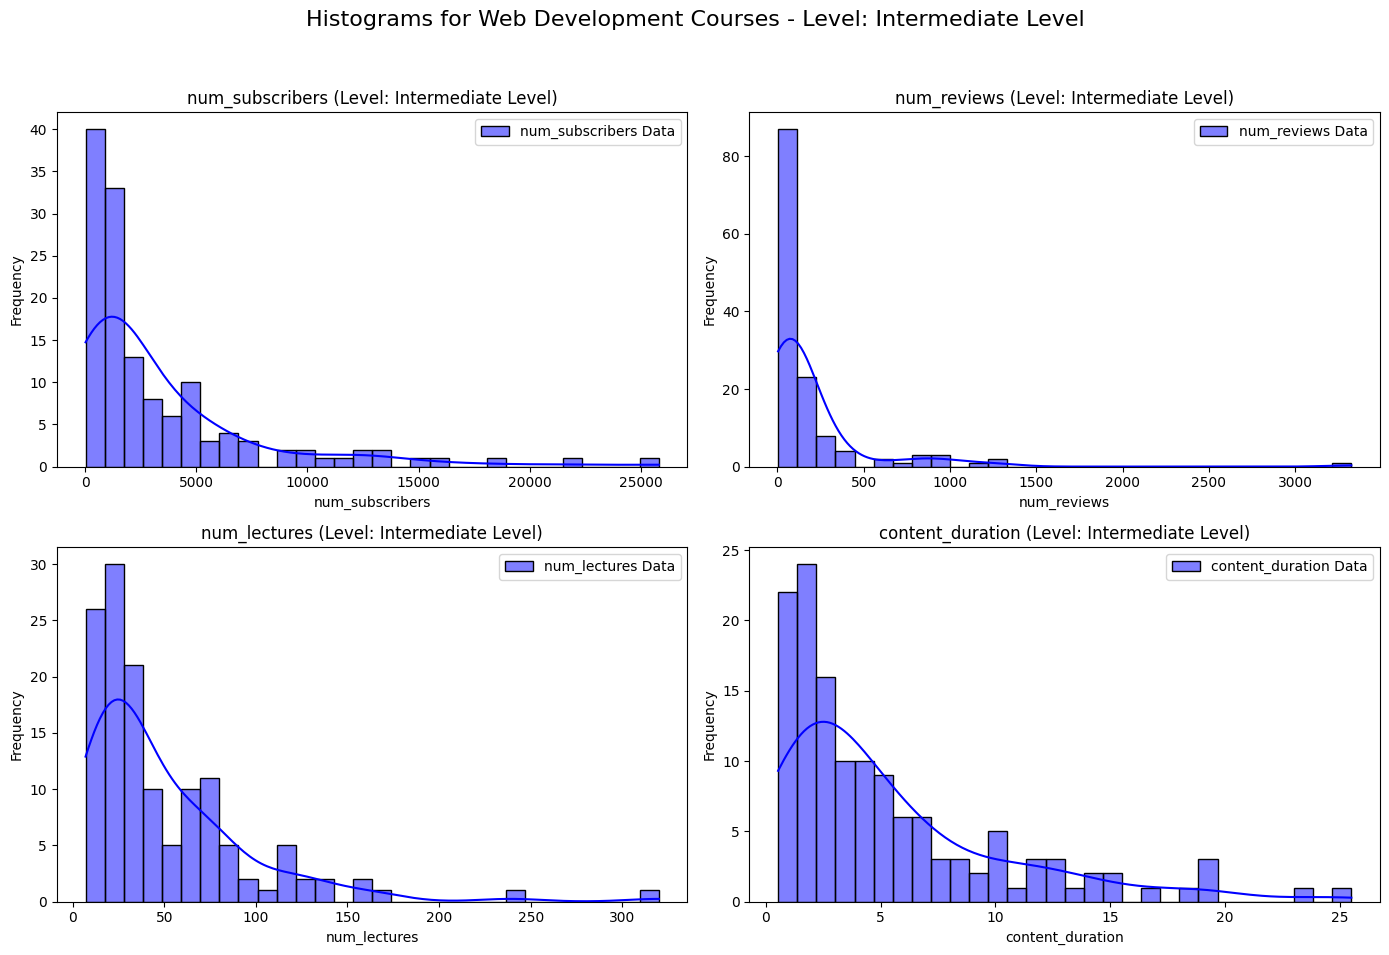

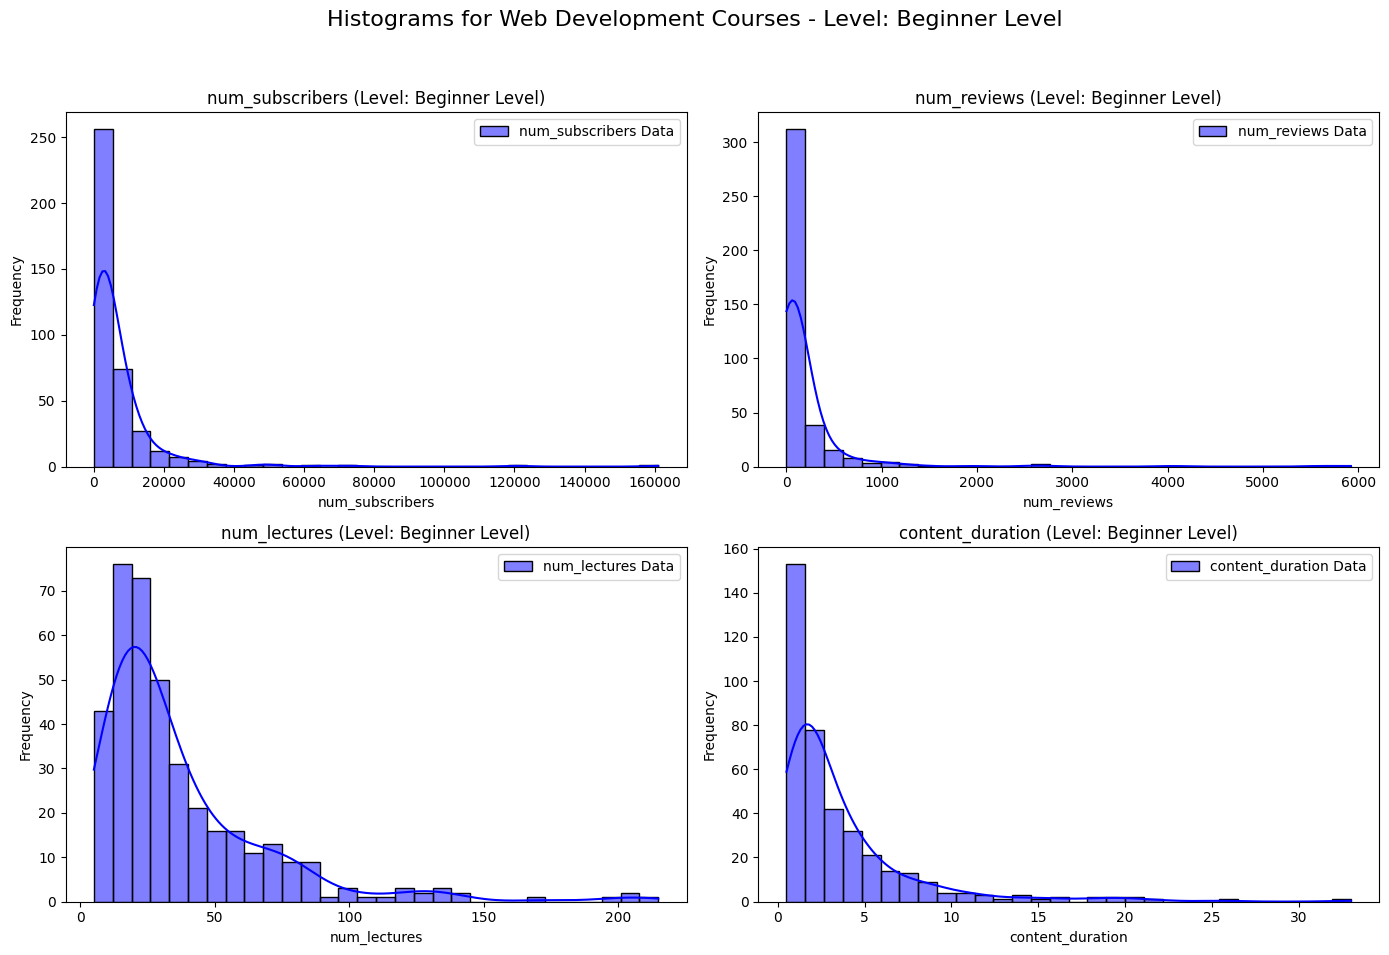

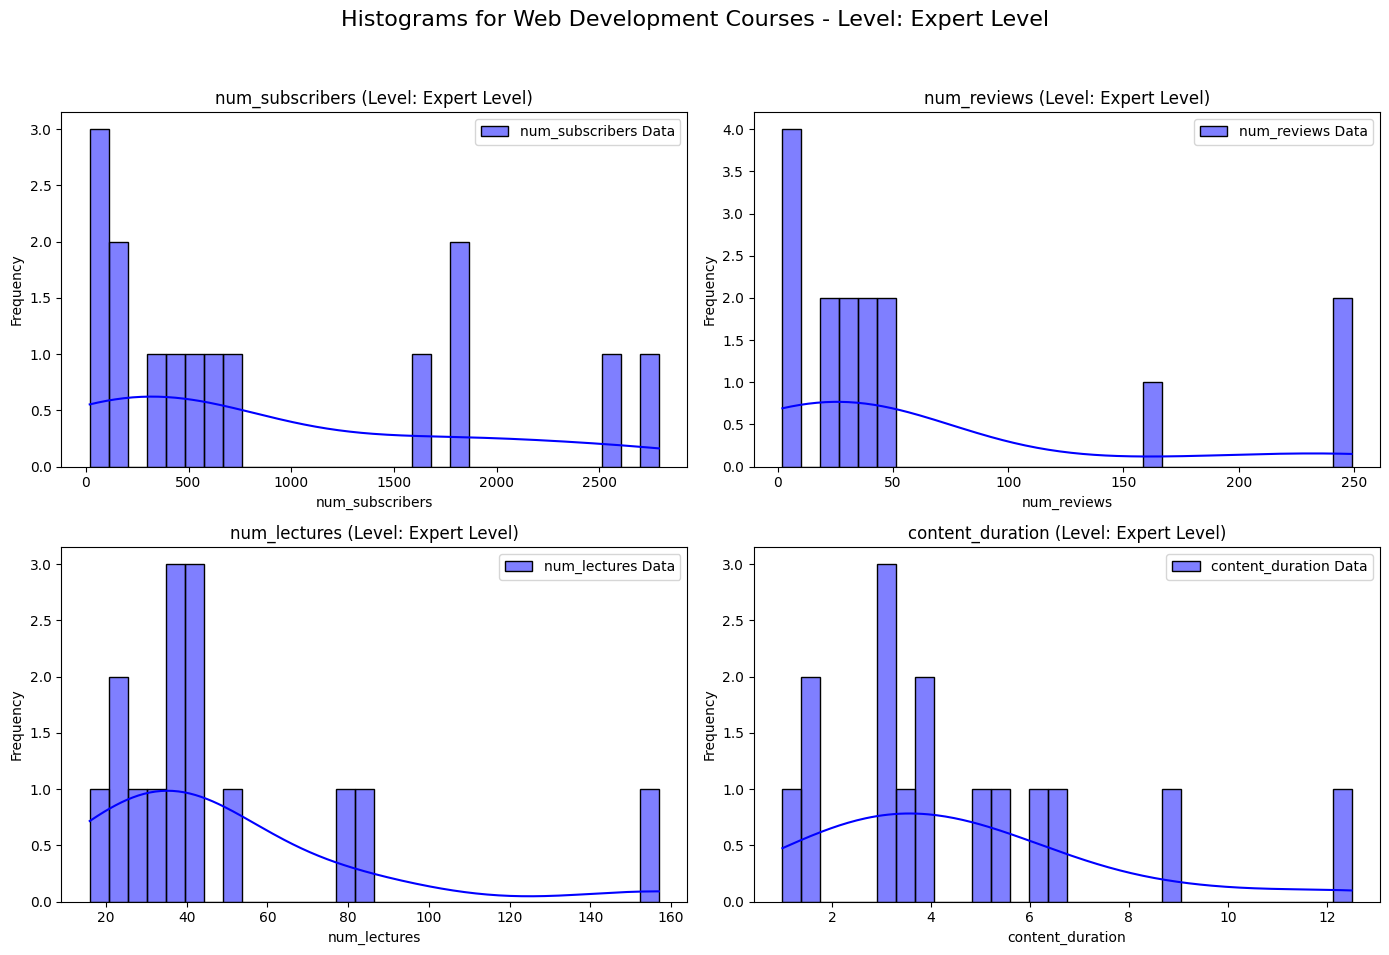

In [169]:
# Filter data for Web Development courses
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# List of independent variables
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Unique levels in the 'level' column
lecture_levels = web_dev_courses['level'].unique()

# Create histograms grouped by lecture level
for level in lecture_levels:
    level_data = web_dev_courses[web_dev_courses['level'] == level]
    plt.figure(figsize=(14, 10))
    plt.suptitle(f'Histograms for Web Development Courses - Level: {level}', fontsize=16)
    
    for i, var in enumerate(independent_vars, 1):
        plt.subplot(2, 2, i)

        sns.histplot(level_data[var], kde=True, color='blue', label=f'{var} Data', bins=30)
        
        plt.title(f'{var} (Level: {level})')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
    plt.show()


Mean Squared Error: 3299.587562441589
R-squared: 0.10231354991737096

Lasso Coefficients:
            Feature  Coefficient
0   num_subscribers    -2.283554
1       num_reviews     3.155279
2      num_lectures    14.527576
3  content_duration     6.430394


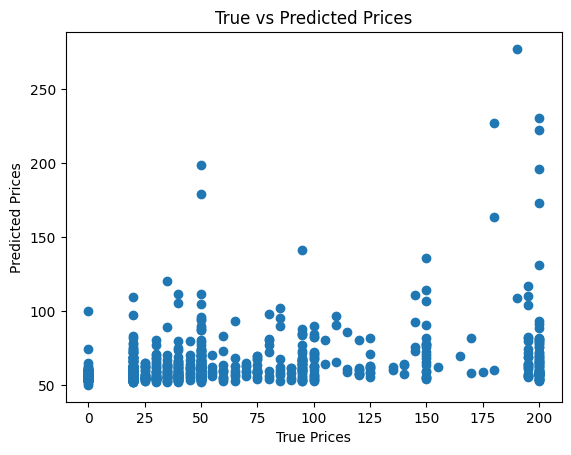

In [ ]:
X = df[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']]  
y = df['price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1)  
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("\nLasso Coefficients:")
print(coefficients)

plt.scatter(y_test, y_pred)
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("True vs Predicted Prices")
plt.show()


BOX 8 BARCHART: count all the courses taking into account the subject

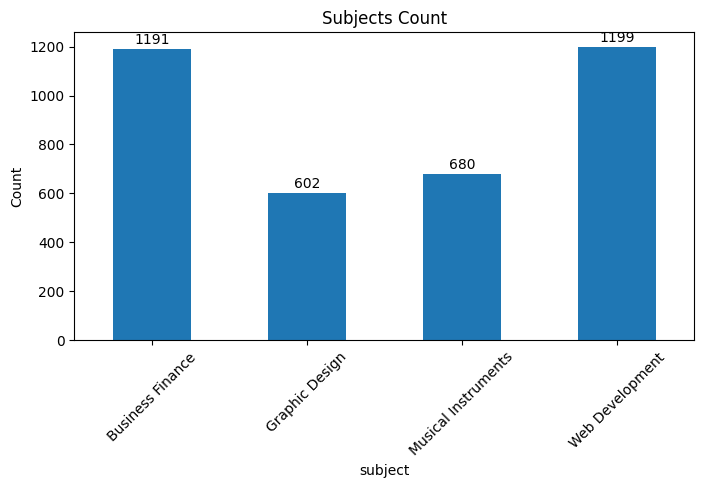

In [ ]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 9: Chi square for courses based on subj
H₀: There is no statistical difference in the number of couses per subject
H₁: There is a statistical difference in the number of couses per subject for at least one subject

In [ ]:
observed_cat = category.values  
chi_square_test(observed_cat)

{'Chi-Square Statistic: 337.67973856209153',
 'P-Value: 6.938242224702548e-73',
 'Result: reject the null hypothesis'}

BOX 10 BARCHART: avg duration per subject

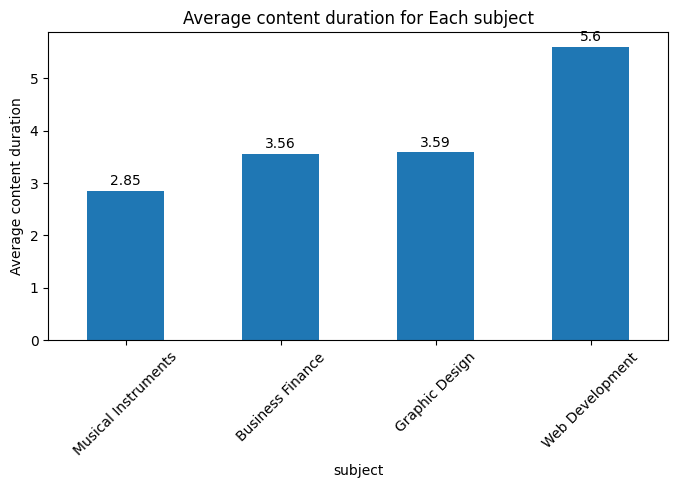

In [ ]:
avg_duration_subj = df.groupby('subject')['content_duration'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_duration_subj.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_duration_subj.plot(kind='bar')
plt.title('Average content duration for Each subject')
plt.xlabel('subject')
plt.ylabel('Average content duration')
plt.xticks(rotation=45)
plt.show()

BOX 11 Chi Square for avr duration based on each subject
H₀: all subjects have a similar value for the avg duration 
H₁: at least one subject has a different value for the avg duration

In [ ]:
observed_avg_duration = avg_duration_subj.values
chi_square_test(observed_avg_duration)

{'Chi-Square Statistic: 1.0738276876778154',
 'P-Value: 0.7833956419700129',
 'Result: fail to reject the null hypothesis'}

BOX 12 BARCHART: total number of subscribers enrolled for each subject

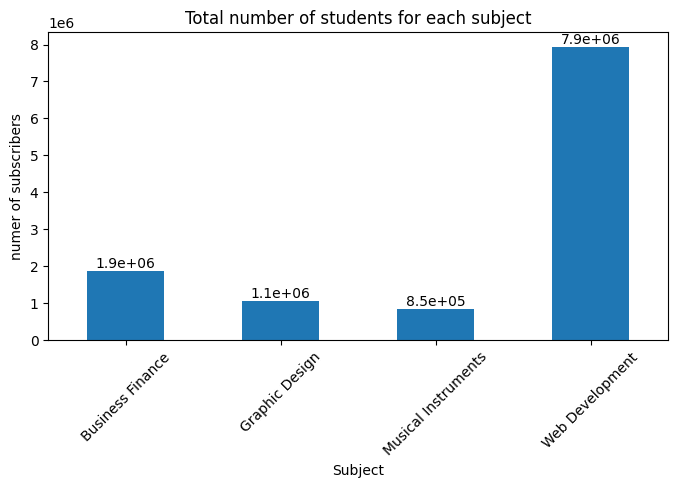

In [ ]:
total_enrolled_stud = df.groupby('subject')['num_subscribers'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 13 Chi Square for total number of subscribers enrolled in each subject
H₀: all subjects have a similar number of students enrolled
H₁: at least one subject has a different number of students enrolled

In [ ]:
observed_total_subscribers = total_enrolled_stud.values
chi_square_test(observed_total_subscribers)

{'Chi-Square Statistic: 11616610.926223781',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

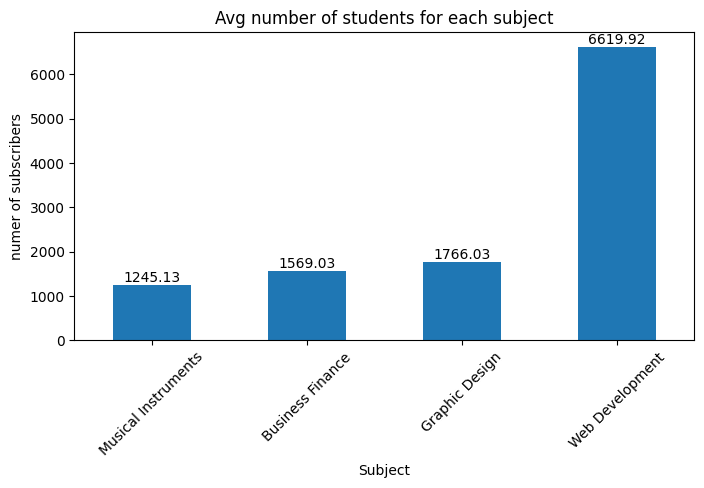

In [ ]:
avg_enrolled_stud = df.groupby('subject')['num_subscribers'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_enrolled_stud.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_enrolled_stud.plot(kind='bar')
plt.title('Avg number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 14 BARCHART: total number of reviews for each subject

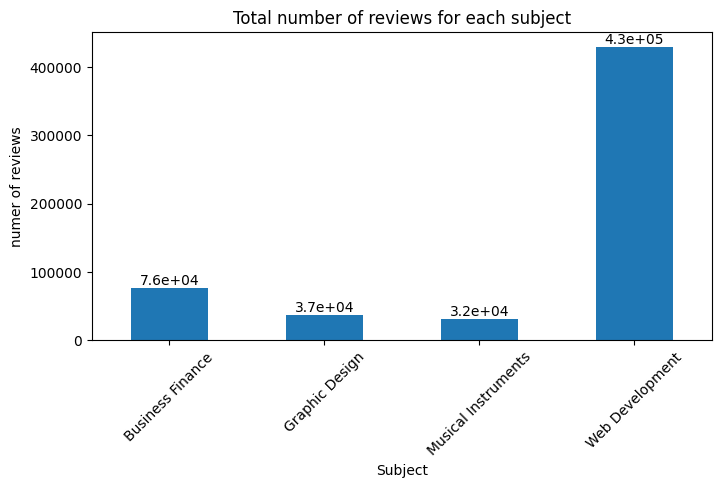

In [ ]:
total_reviews = df.groupby('subject')['num_reviews'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_reviews.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_reviews.plot(kind='bar')
plt.title('Total number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 15: Chi Square test for total number of reviews
H0: The is no significant difference in the number of reviews across all subjects
H1: At least one subject has a different number of reviews that others

In [ ]:
observed_total_reviews = total_reviews.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

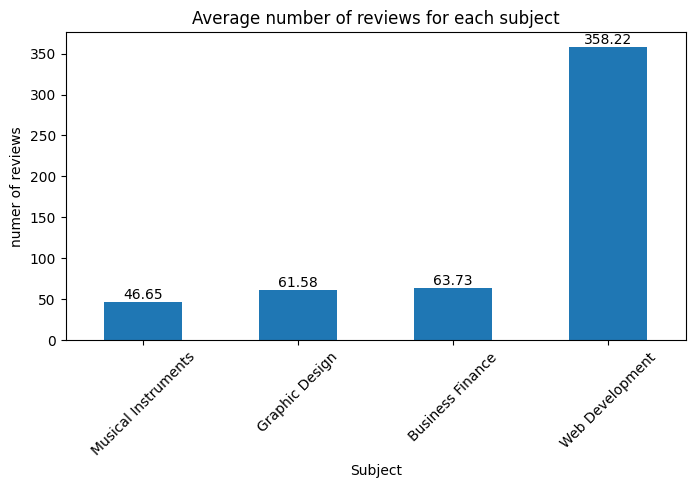

In [ ]:
avg_reviews = df.groupby('subject')['num_reviews'].mean().sort_values(ascending=True)



plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_reviews.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_reviews.plot(kind='bar')
plt.title('Average number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 16 BARCHART: total number of professors for each subject

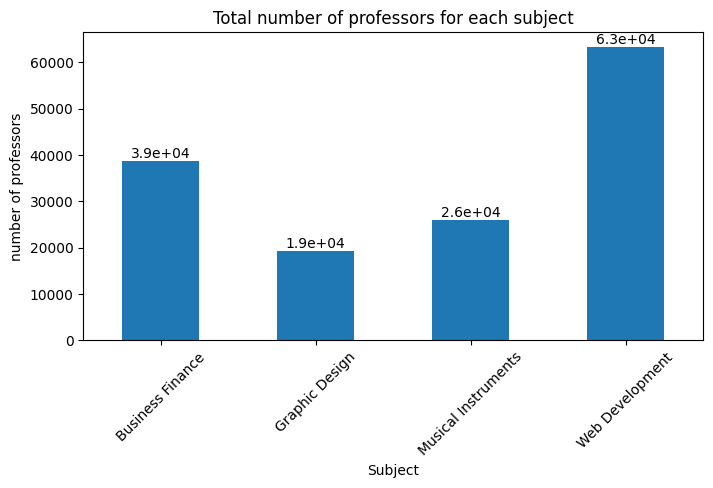

In [ ]:
total_professors = df.groupby('subject')['num_lectures'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_professors.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_professors.plot(kind='bar')
plt.title('Total number of professors for each subject')
plt.xlabel('Subject')
plt.ylabel('number of professors')
plt.xticks(rotation=45)
plt.show()

BOX 17: Chi Square for number of professors
H0: There is no statistical difference between the number of professors per subject
H1: At last one subject has a different number of professors than the others

In [ ]:
observed_total_professors= total_professors.values
chi_square_test(observed_total_professors)

{'Chi-Square Statistic: 30658.86730893178',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 18 BARCHART: avg prices for each subject

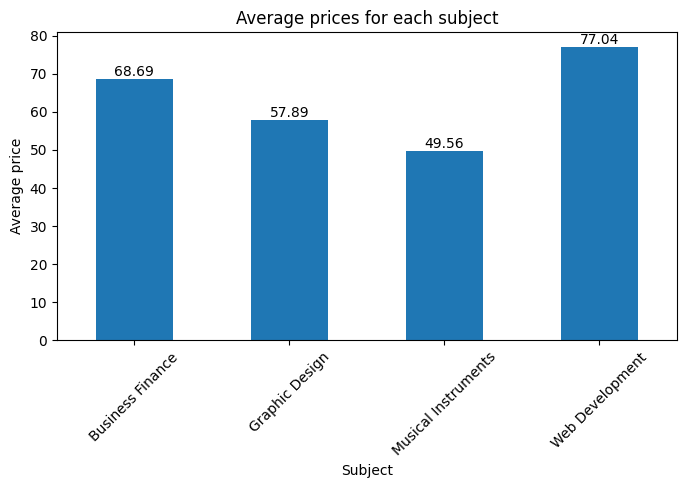

In [ ]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

BOX 19: Chi Square test for avg prices per subject
H0: There is no statistical difference between the avg price per subject
H1: At last one subject has a different agv price than the others

In [ ]:
observed_avg_price = avg_price.values
chi_square_test(observed_avg_price)

{'Chi-Square Statistic: 6.88579963278157',
 'P-Value: 0.07562818840722958',
 'Result: fail to reject the null hypothesis'}

BOX 20: Checking price values over time for every category

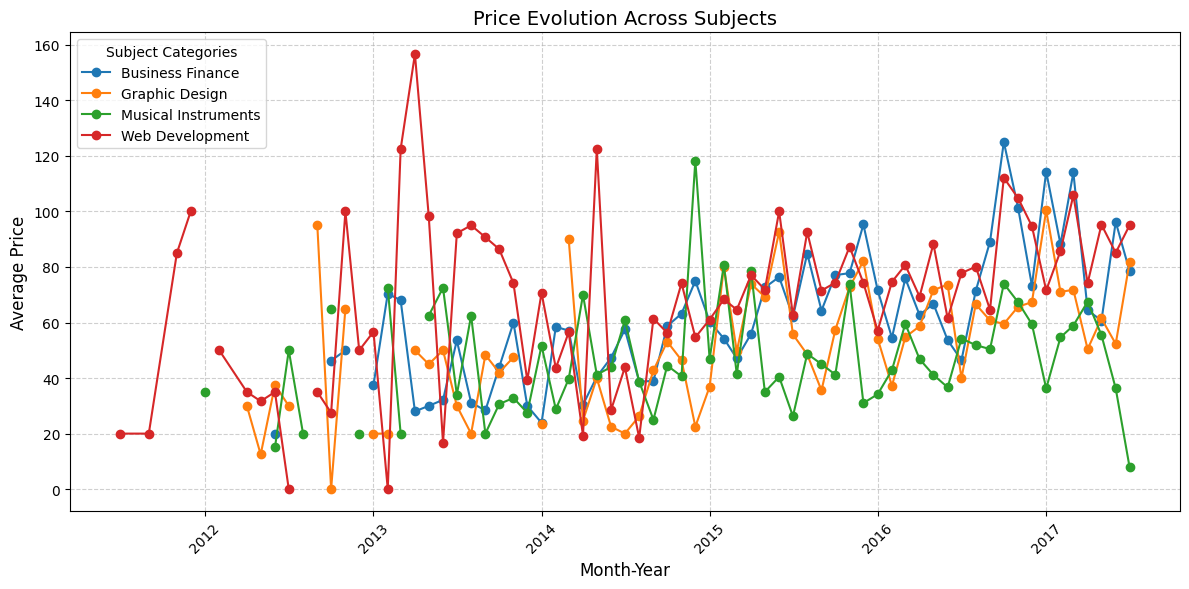

In [ ]:
df["published_timestamp"] = pd.to_datetime(df["published_timestamp"])
df["Month-Year"] = df["published_timestamp"].dt.strftime("%b-%Y")

grouped = df.groupby(["subject", "Month-Year"], as_index=False)["price"].mean()

pivoted = grouped.pivot(index="Month-Year", columns="subject", values="price")

pivoted.index = pd.to_datetime(pivoted.index, format="%b-%Y")
pivoted = pivoted.sort_index()

plt.figure(figsize=(12, 6))
for category in pivoted.columns:
    plt.plot(pivoted.index, pivoted[category], marker="o", label=category)

plt.title("Price Evolution Across Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BOX 21: Avg price per subject taking into account all categories

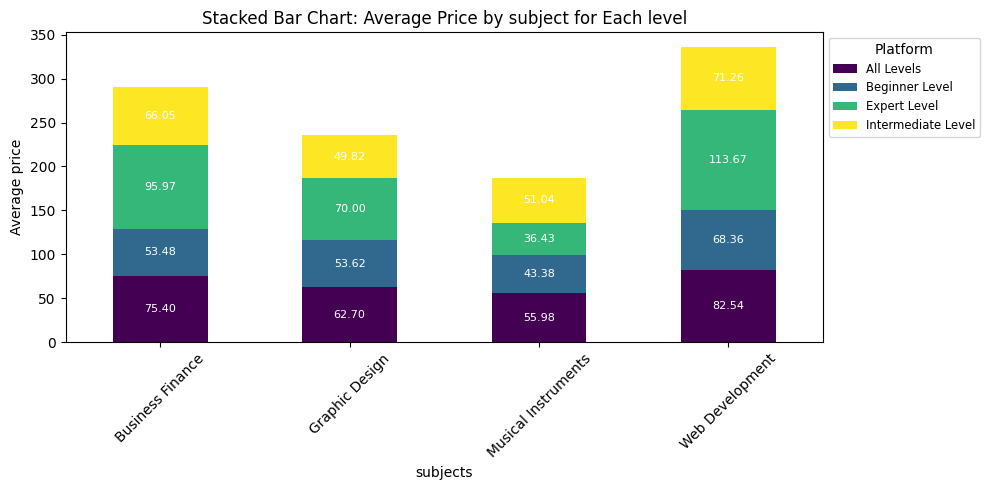

In [ ]:
avg_price_per_category = df.groupby(['subject', 'level'])['price'].mean().unstack()

ax = avg_price_per_category.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)


for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        if bar.get_height() > 0:  
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_y() + height / 2,          
                f'{height:.2f}',                   
                ha='center', va='center', fontsize=8, color='white'
            )

plt.title('Stacked Bar Chart: Average Price by subject for Each level')
plt.xlabel('subjects')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.legend(title='Platform', fontsize='small', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

plt.show()

BOX 20: Checking distribution for price

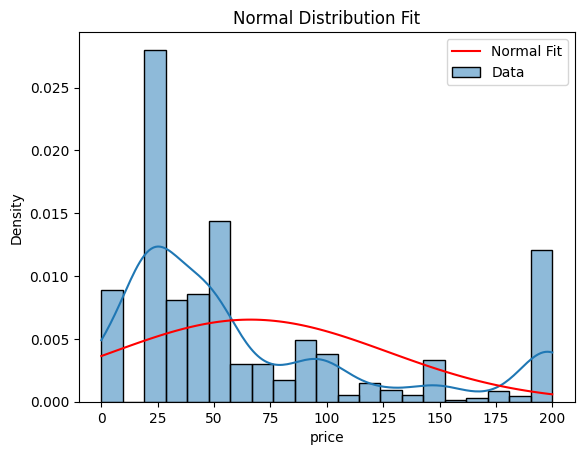

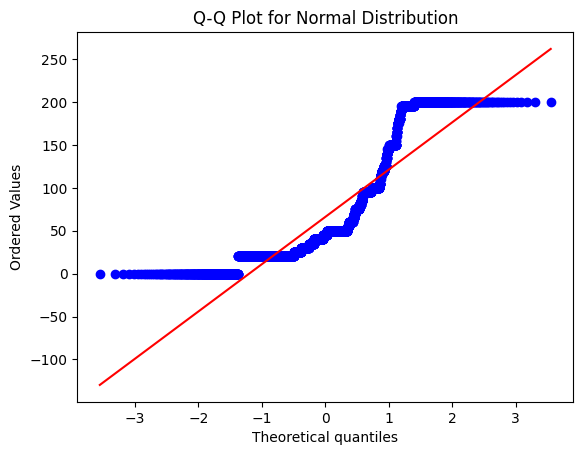

Shapiro-Wilk Test: Stat=0.8125917569824538, p=2.8372585758096045e-54
Data does not follow a normal distribution.


In [ ]:
prices = df['price']

sns.histplot(prices, kde=True, stat='density', label='Data')
mean, std = prices.mean(), prices.std()
x = np.linspace(prices.min(), prices.max(), 100)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normal Fit', color='red')
plt.title('Normal Distribution Fit')
plt.legend()
plt.show()

stats.probplot(prices, dist="norm", plot=plt)
plt.title('Q-Q Plot for Normal Distribution')
plt.show()

stat, p = stats.shapiro(prices)
print(f'Shapiro-Wilk Test: Stat={stat}, p={p}')
if p > 0.05:
    print("Data follows a normal distribution.")
else:
    print("Data does not follow a normal distribution.")


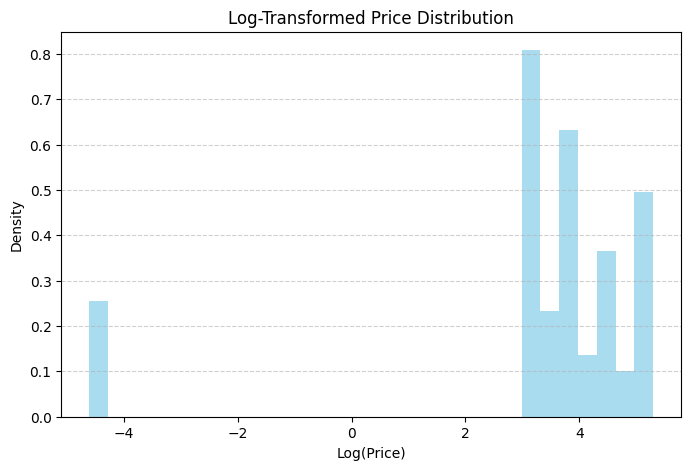

In [ ]:
df['price_log'] = np.log(df['price'].replace(0, 0.01))

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_log'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


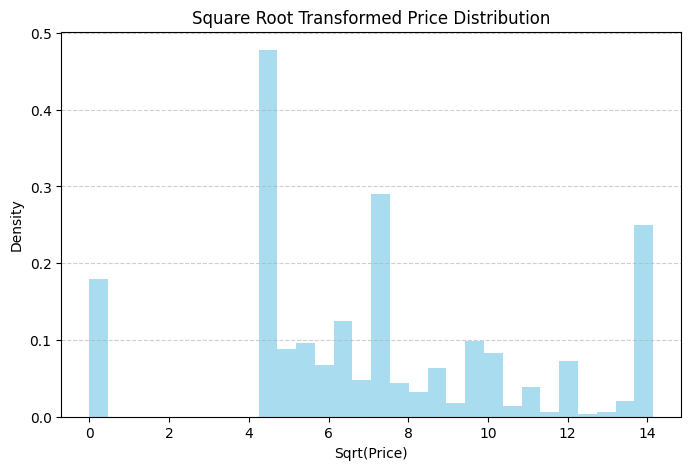

In [ ]:
df['price_sqrt'] = np.sqrt(df['price'])

plt.figure(figsize=(8, 5))
plt.hist(df['price_sqrt'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Square Root Transformed Price Distribution')
plt.xlabel('Sqrt(Price)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

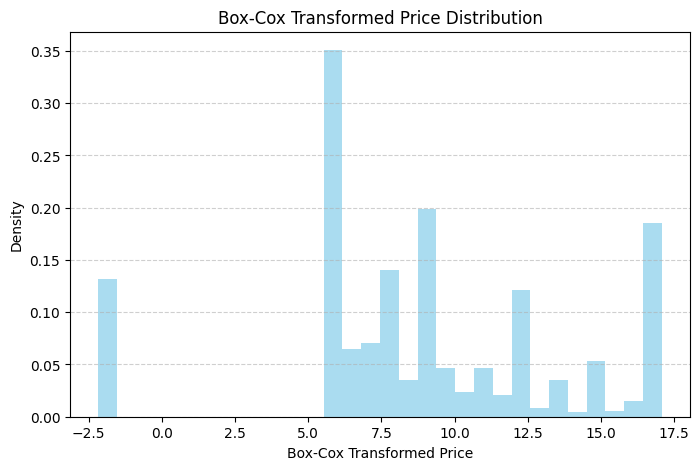

In [ ]:
from scipy.stats import boxcox

# Ensure no zero prices by replacing zero with a small value
df['price_adjusted'] = df['price'].replace(0, 0.01)

# Apply Box-Cox transformation
df['price_boxcox'], lambda_ = boxcox(df['price_adjusted'])

# Plot the transformed distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price_boxcox'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox Transformed Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


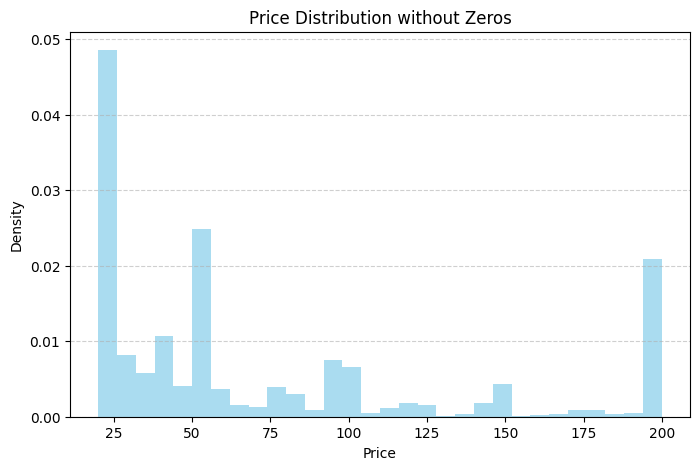

Shapiro-Wilk Test: Stat = 0.7862613045584798, p-value = 7.020117445293386e-55


In [ ]:
# Remove rows where price is zero
df_non_zero_price = df[df['price'] > 0]

# Plot the original distribution without zeros
plt.figure(figsize=(8, 5))
plt.hist(df_non_zero_price['price'], bins=30, color='skyblue', alpha=0.7, density=True)
plt.title('Price Distribution without Zeros')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

from scipy import stats

# Shapiro-Wilk Test for normality
stat, p_value = stats.shapiro(df_non_zero_price['price'])
print(f"Shapiro-Wilk Test: Stat = {stat}, p-value = {p_value}")



In [ ]:
# params = stats.expon.fit(prices)  
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.expon.pdf(x, *params), label='Exponential Fit', color='green')
# plt.title('Exponential Distribution Fit')
# plt.legend()
# plt.show()

# stats.probplot(prices, dist="expon", sparams=params, plot=plt)
# plt.title('Q-Q Plot for Exponential Distribution')
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'expon', args=params)
# print(f'KS Test for Exponential: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows an exponential distribution.")
# else:
#     print("Data does not follow an exponential distribution.")

In [ ]:
# log_prices = np.log1p(prices)  # log(1+x) to handle zeros
# sns.histplot(log_prices, kde=True, stat='density', label='Log Data')
# plt.title('Logarithmic Distribution Fit')
# plt.legend()
# plt.show()

# # Q-Q Plot
# stats.probplot(log_prices, dist="norm", plot=plt)
# plt.title('Q-Q Plot for Logarithmic Distribution')
# plt.show()

# # Shapiro-Wilk Test
# stat, p = stats.shapiro(log_prices)
# print(f'Shapiro-Wilk Test on Log Transformed Data: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Log-transformed data follows a normal distribution.")
# else:
#     print("Log-transformed data does not follow a normal distribution.")

In [ ]:
# # Fit Gamma Distribution
# params = stats.gamma.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.gamma.pdf(x, *params), label='Gamma Fit', color='purple')
# plt.title('Gamma Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'gamma', args=params)
# print(f'KS Test for Gamma: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a gamma distribution.")
# else:
#     print("Data does not follow a gamma distribution.")


In [ ]:
# # Fit Weibull Distribution
# params = stats.weibull_min.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.weibull_min.pdf(x, *params), label='Weibull Fit', color='orange')
# plt.title('Weibull Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'weibull_min', args=params)
# print(f'KS Test for Weibull: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a Weibull distribution.")
# else:
#     print("Data does not follow a Weibull distribution.")


In [ ]:
# # Normalize data to fit [0, 1]
# normalized_prices = (prices - prices.min()) / (prices.max() - prices.min())

# # Fit Beta Distribution
# params = stats.beta.fit(normalized_prices)
# sns.histplot(normalized_prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.beta.pdf(x, *params), label='Beta Fit', color='green')
# plt.title('Beta Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(normalized_prices, 'beta', args=params)
# print(f'KS Test for Beta: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a beta distribution.")
# else:
#     print("Data does not follow a beta distribution.")


In [ ]:
# # Fit Log-Normal Distribution
# params = stats.lognorm.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.lognorm.pdf(x, *params), label='Log-Normal Fit', color='blue')
# plt.title('Log-Normal Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'lognorm', args=params)
# print(f'KS Test for Log-Normal: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a log-normal distribution.")
# else:
#     print("Data does not follow a log-normal distribution.")


In [ ]:
# # Fit Chi-Square Distribution
# params = stats.chi2.fit(prices)
# sns.histplot(prices, kde=False, stat='density', label='Data')
# plt.plot(x, stats.chi2.pdf(x, *params), label='Chi-Square Fit', color='brown')
# plt.title('Chi-Square Distribution Fit')
# plt.legend()
# plt.show()

# # Kolmogorov-Smirnov Test
# stat, p = stats.kstest(prices, 'chi2', args=params)
# print(f'KS Test for Chi-Square: Stat={stat}, p={p}')
# if p > 0.05:
#     print("Data follows a chi-square distribution.")
# else:
#     print("Data does not follow a chi-square distribution.")


In [ ]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
# gmm.fit(prices.values.reshape(-1, 1))
# sns.histplot(prices, kde=False, stat="density", label="Data")
# x = np.linspace(prices.min(), prices.max(), 1000).reshape(-1, 1)
# pdf = np.exp(gmm.score_samples(x))
# plt.plot(x, pdf, label="GMM Fit", color="red")
# plt.title("Gaussian Mixture Model Fit")
# plt.legend()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# # Empirical data (price)
# data = prices

# # Histogram for empirical density
# counts, bin_edges = np.histogram(data, bins=20, density=True)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # Fit a distribution (e.g., Normal)
# dist_name = 'norm'  # Change to other distributions like 'expon', 'gamma'
# params = getattr(stats, dist_name).fit(data)
# pdf_fitted = getattr(stats, dist_name).pdf(bin_centers, *params)

# # Calculate RMSE
# rmse = np.sqrt(np.mean((counts - pdf_fitted) ** 2))

# # Plot for visualization
# plt.hist(data, bins=20, density=True, alpha=0.5, label="Empirical Data")
# plt.plot(bin_centers, pdf_fitted, label=f"{dist_name.capitalize()} Fit", color="red")
# plt.title(f"{dist_name.capitalize()} Distribution Fit (RMSE: {rmse:.4f})")
# plt.xlabel("Price")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

# print(f"RMSE for {dist_name.capitalize()} distribution: {rmse:.4f}")


BOX 20: checking normal distibutions

In [ ]:
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     print(f"\nAnalyzing {column}:")

#     plt.figure(figsize=(12, 6))
#     sns.histplot(df[column].dropna(), kde=True, stat="density", color="skyblue", label="Data Density")
 
#     mean, std = norm.fit(df[column].dropna()) 
#     x = np.linspace(df[column].min(), df[column].max(), 100)
#     p = norm.pdf(x, mean, std)
#     plt.plot(x, p, 'r--', label="Normal Fit")
#     plt.title(f"Histogram with Normal Fit for {column}")
#     plt.legend()
#     plt.show()

#     plt.figure(figsize=(6, 6))
#     from scipy.stats import probplot
#     probplot(df[column].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot for {column}")
#     plt.show()

#     stat, p_value = shapiro(df[column].dropna())
#     print(f"Shapiro-Wilk Test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}")
    
#     if p_value < 0.05:
#         print(f"{column} does NOT follow a normal distribution.")
#     else:
#         print(f"{column} follows a normal distribution.")

RELATIONSHIP BETWEEN VARIABLES

BOX 1: COVARIANCE MATRIX

In [ ]:
numeric_columns = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']
numeric_data = df[numeric_columns]

covariance_matrix = numeric_data.cov()

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                         price  num_subscribers   num_reviews  num_lectures  \
price              3725.383571     2.920833e+04  6.489357e+03   1015.321979   
num_subscribers   29208.332379     9.002415e+07  5.783174e+06  75749.221400   
num_reviews        6489.357284     5.783174e+06  8.764305e+05  11470.339062   
num_lectures       1015.321979     7.574922e+04  1.147034e+04   2541.884165   
content_duration    108.409322     9.318099e+03  1.297867e+03    244.830473   

                  content_duration  
price                   108.409322  
num_subscribers        9318.099228  
num_reviews            1297.867071  
num_lectures            244.830473  
content_duration         36.697302  


BOX 2 Correlation - spearman coeff

In [ ]:
spearman_corr = numeric_data.corr(method='spearman')
print("Spearman Correlation Matrix:")
print(spearman_corr)

Spearman Correlation Matrix:
                     price  num_subscribers  num_reviews  num_lectures  \
price             1.000000         0.065417     0.142063      0.386509   
num_subscribers   0.065417         1.000000     0.784343      0.209673   
num_reviews       0.142063         0.784343     1.000000      0.341210   
num_lectures      0.386509         0.209673     0.341210      1.000000   
content_duration  0.352195         0.168231     0.322259      0.805391   

                  content_duration  
price                     0.352195  
num_subscribers           0.168231  
num_reviews               0.322259  
num_lectures              0.805391  
content_duration          1.000000  


BOX 3: the relationship between all numeric variables 2 by 2 

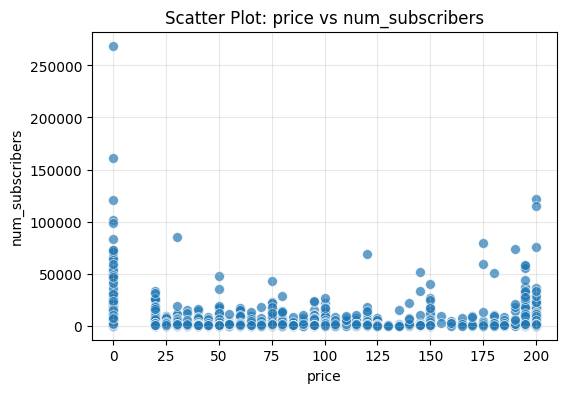

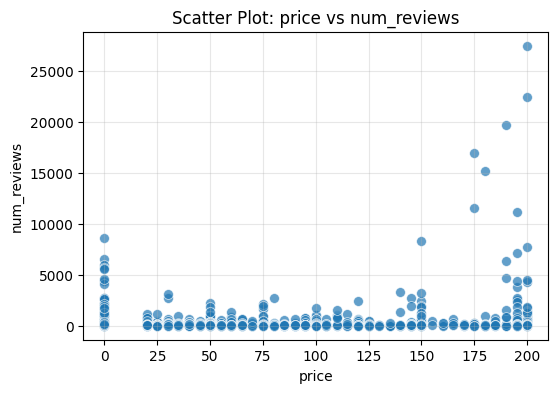

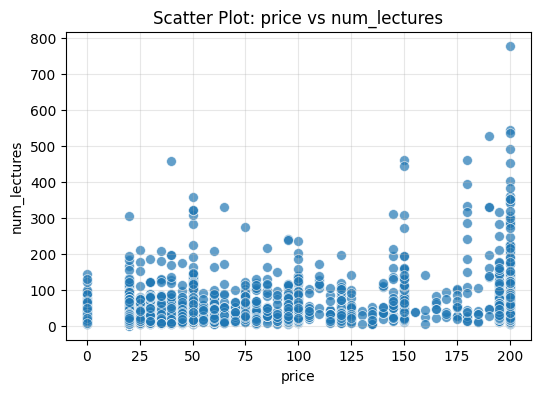

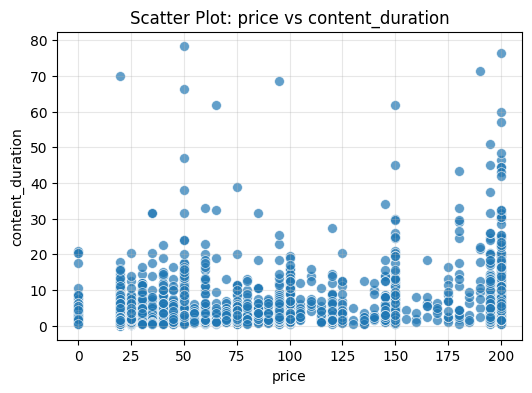

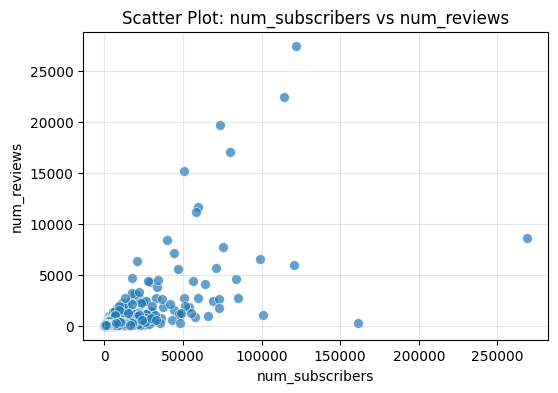

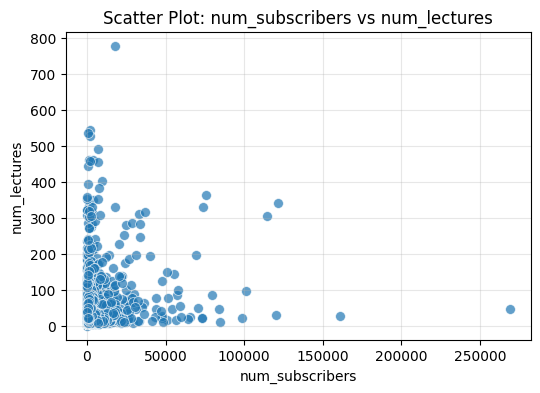

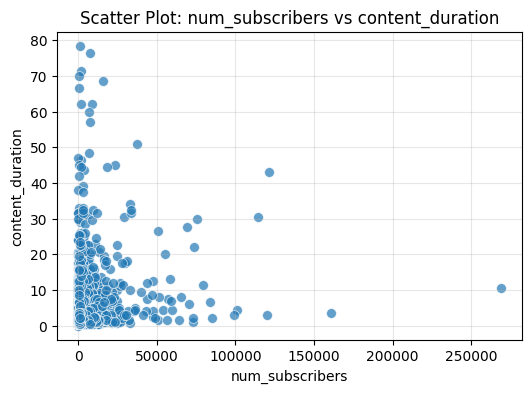

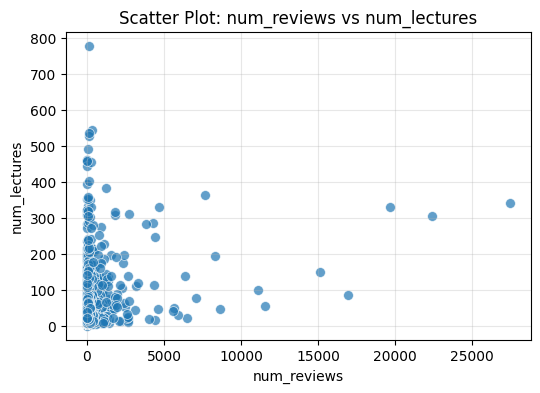

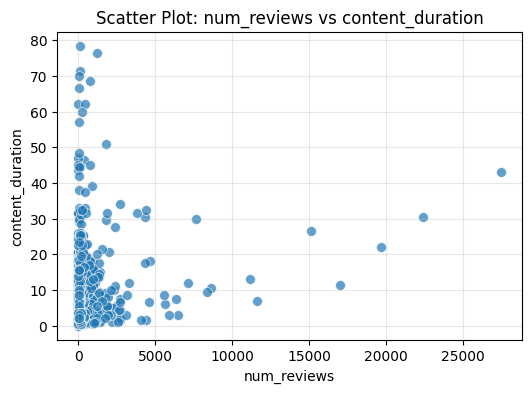

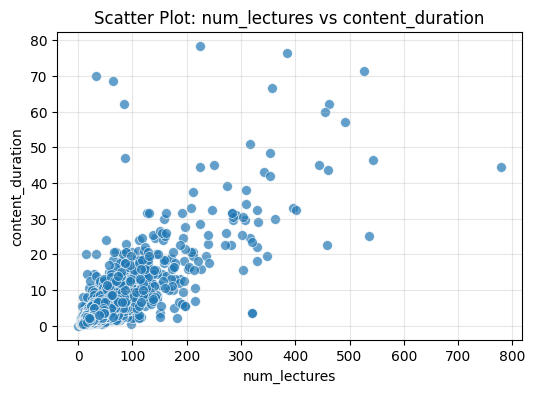

In [ ]:
for i, col1 in enumerate(numeric_columns):
    for col2 in numeric_columns[i+1:]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=numeric_data, x=col1, y=col2, alpha=0.7, s=50)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(alpha=0.3)
        plt.show()

BOX 4: Multicollinearity - Correlation Matrix

In [185]:
# Calculate correlation matrix
correlation_matrix = df_no_outliers_udemy.select_dtypes(include=['float64', 'int64']).corr()

# Display correlation matrix
print(correlation_matrix)


                  course_id     price  num_subscribers  num_reviews  \
course_id          1.000000  0.148260        -0.155283    -0.081856   
price              0.148260  1.000000         0.023783     0.078141   
num_subscribers   -0.155283  0.023783         1.000000     0.699118   
num_reviews       -0.081856  0.078141         0.699118     1.000000   
num_lectures      -0.008727  0.313340         0.099088     0.233474   
content_duration  -0.036473  0.300064         0.120606     0.234794   

                  num_lectures  content_duration  
course_id            -0.008727         -0.036473  
price                 0.313340          0.300064  
num_subscribers       0.099088          0.120606  
num_reviews           0.233474          0.234794  
num_lectures          1.000000          0.810548  
content_duration      0.810548          1.000000  


STARTING THE REGRESSION

creating interaction terms since the correlation is high between num_lectures-content_duration and num_reviews-num_subscribers

In [186]:
df_no_outliers_udemy['num_lectures_content_duration'] = df_no_outliers_udemy['num_lectures'] * df_no_outliers_udemy['content_duration']
df_no_outliers_udemy['num_subscribers_num_reviews'] = df_no_outliers_udemy['num_subscribers'] * df_no_outliers_udemy['num_reviews']


C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\3114344232.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\3114344232.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1. MULTIPLE LINEAR REGRESSION

In [ ]:
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)






Mean Squared Error: 3354.8036312587424
R-squared: 0.08099357723583911

Linear Regression Coefficients:
                    Feature  Coefficient
0           num_subscribers    -1.280287
1               num_reviews     1.535396
2              num_lectures    12.687619
3          content_duration     7.262236
4      level_Beginner Level    -5.806305
5        level_Expert Level     3.377891
6  level_Intermediate Level    -2.950774


MULTIMPLE LINEAR REGRESSION WITH INTERACTION TERM

In [195]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)






Mean Squared Error: 3345.8839155314663
R-squared: 0.08343702160504696

Linear Regression Coefficients:
                       Feature  Coefficient
0  num_subscribers_num_reviews    -1.873820
1                 num_lectures    12.880387
2             content_duration     7.457322
3         level_Beginner Level    -5.851472
4           level_Expert Level     3.374157
5     level_Intermediate Level    -2.962439


2. POLINOMIAL REGRESSION 

In [204]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = df_no_outliers_udemy['price']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=2)  # degree 2 for quadratic features
X_poly = poly.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Fit a Linear Regression model
lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)

# Evaluate the model
y_pred = lr_poly.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 3360.778448019717
R-squared: 0.07935685104208734


Plotting the residuals => heteroscedasticity

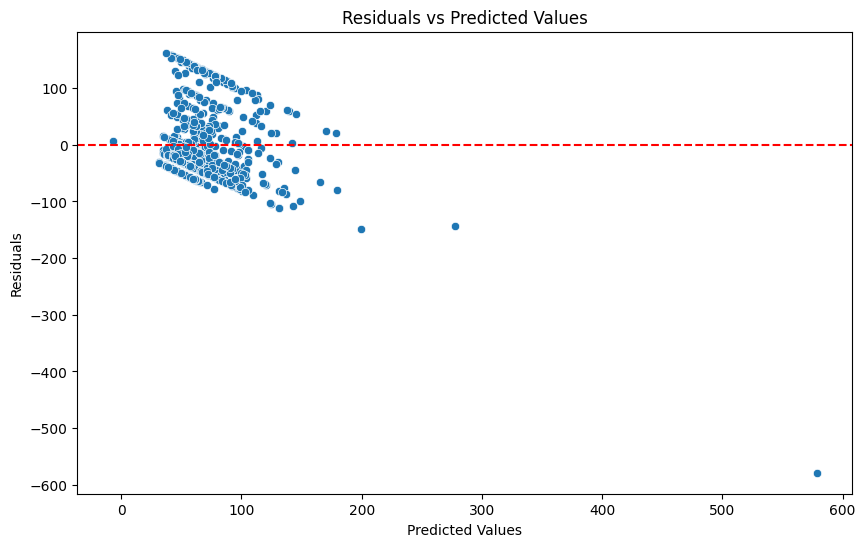

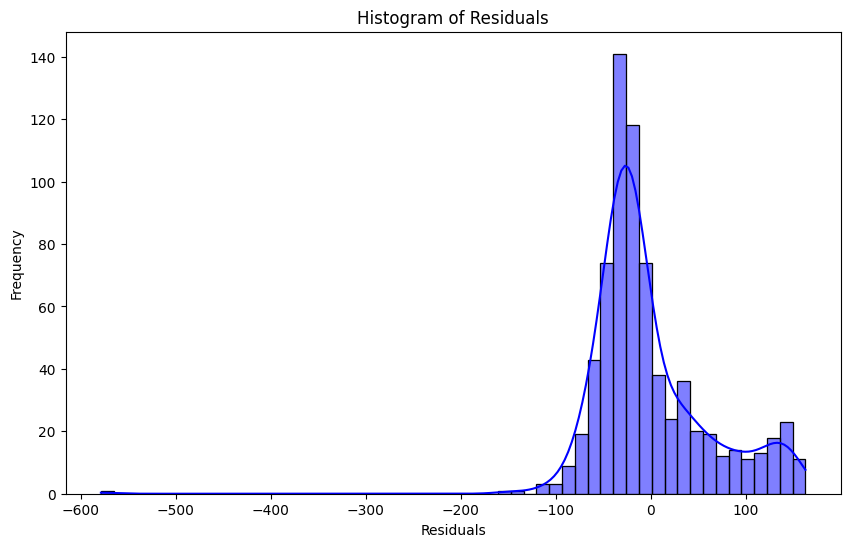

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Optionally: Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


log-transformation on price

C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\1684558998.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



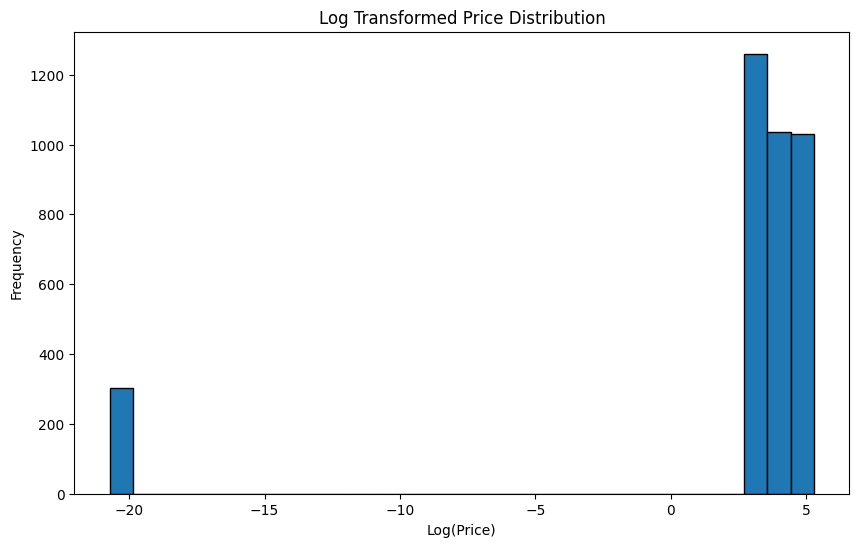

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Log transformation of price
df_no_outliers_udemy['price_log'] = np.log(df_no_outliers_udemy['price']+ 1e-9)

# Plotting the distribution of the log-transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_log'], bins=30, edgecolor='black')
plt.title('Log Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()


Box-Cox transformation

C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\1166568702.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\1166568702.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



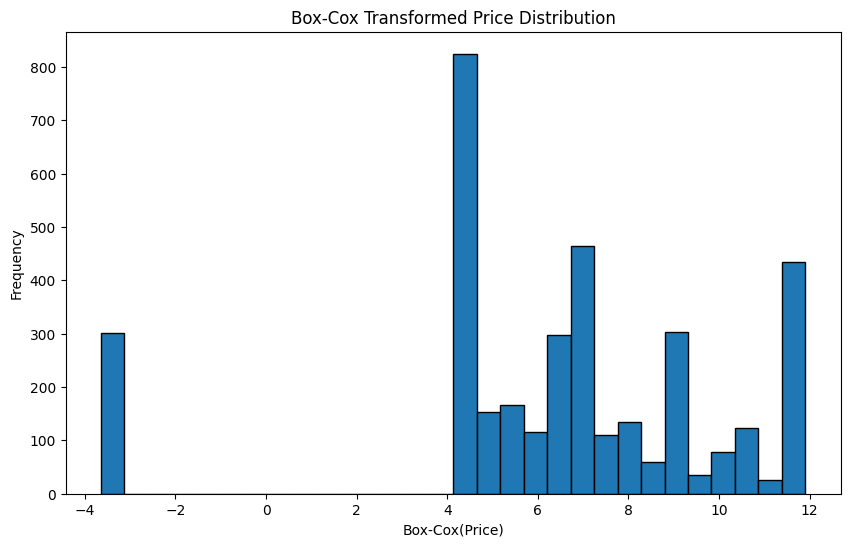

Lambda for Box-Cox transformation: 0.2732505653361542


In [208]:
from scipy import stats

# Adding a small constant to avoid zero or negative values
df_no_outliers_udemy['price_boxcox'] = df_no_outliers_udemy['price'] + 1e-9

# Applying Box-Cox transformation
df_no_outliers_udemy['price_boxcox'], lambda_boxcox = stats.boxcox(df_no_outliers_udemy['price_boxcox'])

# Plotting the distribution of the Box-Cox transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_boxcox'], bins=30, edgecolor='black')
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox(Price)')
plt.ylabel('Frequency')
plt.show()

# Check the lambda value for Box-Cox transformation
print(f"Lambda for Box-Cox transformation: {lambda_boxcox}")


Yeo-Johnson transformation on price

C:\Users\teodo\AppData\Local\Temp\ipykernel_3732\233437185.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



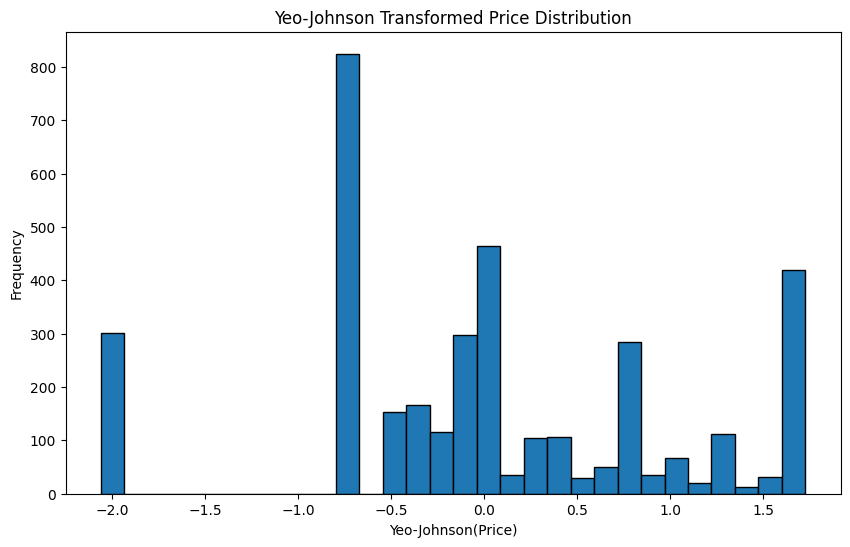

In [221]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df_no_outliers_udemy['price_yeojohnson'] = pt.fit_transform(df_no_outliers_udemy[['price']])

# Plotting the distribution of the Yeo-Johnson transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_yeojohnson'], bins=30, edgecolor='black')
plt.title('Yeo-Johnson Transformed Price Distribution')
plt.xlabel('Yeo-Johnson(Price)')
plt.ylabel('Frequency')
plt.show()


Checking what transformation is the best => Yeo-Johnson

In [212]:
# Check skewness and kurtosis before and after transformations
original_skew = df_no_outliers_udemy['price'].skew()
original_kurtosis = df_no_outliers_udemy['price'].kurtosis()

price_log_skew = df_no_outliers_udemy['price_log'].skew()
price_log_kurtosis = df_no_outliers_udemy['price_log'].kurtosis()

price_boxcox_skew = df_no_outliers_udemy['price_boxcox'].skew()
price_boxcox_kurtosis = df_no_outliers_udemy['price_boxcox'].kurtosis()

price_yeojohnson_skew = df_no_outliers_udemy['price_yeojohnson'].skew()
price_yeojohnson_kurtosis = df_no_outliers_udemy['price_yeojohnson'].kurtosis()

# Output the results
print(f"Original Price - Skewness: {original_skew}, Kurtosis: {original_kurtosis}")
print(f"Log Transformed Price - Skewness: {price_log_skew}, Kurtosis: {price_log_kurtosis}")
print(f"Box-Cox Transformed Price - Skewness: {price_boxcox_skew}, Kurtosis: {price_boxcox_kurtosis}")
print(f"Yeo-Johnson Transformed Price - Skewness: {price_yeojohnson_skew}, Kurtosis: {price_yeojohnson_kurtosis}")


Original Price - Skewness: 1.1829250686298813, Kurtosis: 0.18011342822538312
Log Transformed Price - Skewness: -2.9527605636346586, Kurtosis: 6.882878823872897
Box-Cox Transformed Price - Skewness: -1.076346477186815, Kurtosis: 1.5251635551910088
Yeo-Johnson Transformed Price - Skewness: -0.04405491220284836, Kurtosis: -0.23002714646044575


Redo all the regressions with Yeo-Johnson for price

In [216]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)

Mean Squared Error: 0.9037964011163541
R-squared: 0.1051944905283223

Linear Regression Coefficients:
                       Feature  Coefficient
0  num_subscribers_num_reviews    -0.072116
1                 num_lectures     0.221748
2             content_duration     0.105793
3         level_Beginner Level    -0.117216
4           level_Expert Level     0.063657
5     level_Intermediate Level    -0.032323


In [231]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# List of continuous variables to add polynomial features for
continuous_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Instantiate PolynomialFeatures with degree 2 (quadratic) and degree 3 (cubic)
poly = PolynomialFeatures(degree=3, include_bias=False)  # Set include_bias=False to avoid adding the intercept term

# Apply the transformation to continuous variables
poly_features = poly.fit_transform(df_no_outliers_udemy[continuous_vars])

# Get the feature names of the new polynomial features
poly_feature_names = poly.get_feature_names_out(continuous_vars)

# Create a DataFrame with the new polynomial features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Combine the polynomial features with the original dataframe
df_poly = pd.concat([df_no_outliers_udemy, poly_df], axis=1)

# Check the first few rows to see the new features
print(df_poly.head())


   course_id                                       course_title  \
0  1070968.0                 Ultimate Investment Banking Course   
1  1113822.0  Complete GST Course & Certification - Grow You...   
2  1006314.0  Financial Modeling for Business Analysts and C...   
3  1210588.0  Beginner to Pro - Financial Analysis in Excel ...   
4  1011058.0       How To Maximize Your Profits Trading Options   

                                                 url is_paid  price  \
0  https://www.udemy.com/ultimate-investment-bank...    True  200.0   
1      https://www.udemy.com/goods-and-services-tax/    True   75.0   
2  https://www.udemy.com/financial-modeling-for-b...    True   45.0   
3  https://www.udemy.com/complete-excel-finance-c...    True   95.0   
4  https://www.udemy.com/how-to-maximize-your-pro...    True  200.0   

   num_subscribers  num_reviews  num_lectures               level  \
0           2147.0         23.0          51.0          All Levels   
1           2792.0        923.0 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration'])

# Define the target variable and features
y = df_no_outliers_udemy['price_yeojohnson']

# Select continuous independent variables
continuous_columns = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Select the features from df_no_outliers_udemy
X = df_no_outliers_udemy[continuous_columns]

# Generate interaction terms only
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(X)

# Generate feature names for the interaction terms
interaction_feature_names = poly.get_feature_names_out(continuous_columns)

# Create a DataFrame for the interaction features
interaction_features_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(interaction_features_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a Ridge regression model
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': interaction_feature_names,
    'Coefficient': ridge.coef_
})

print(coefficients)


Mean Squared Error: 0.8873221838489532
R-squared: 0.1215048236485865
                            Feature  Coefficient
0                   num_subscribers    -0.264717
1                       num_reviews    -0.098296
2                      num_lectures     0.327217
3                  content_duration     0.284857
4       num_subscribers num_reviews     0.128234
5      num_subscribers num_lectures     0.309615
6  num_subscribers content_duration    -0.192319
7          num_reviews num_lectures    -0.081422
8      num_reviews content_duration     0.133344
9     num_lectures content_duration    -0.332751


In [244]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration'])

# Define the target variable and features
y = df_no_outliers_udemy['price_yeojohnson']

# Select continuous independent variables
continuous_columns = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Select the features from df_no_outliers_udemy
X = df_no_outliers_udemy[continuous_columns]

# Generate interaction terms only
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(X)

# Generate feature names for the interaction terms
interaction_feature_names = poly.get_feature_names_out(continuous_columns)

# Create a DataFrame for the interaction features
interaction_features_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(interaction_features_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Tune Ridge regression using cross-validation
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge(random_state=42)
grid_search = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Fit Ridge regression with the best alpha
ridge_best = Ridge(alpha=best_alpha, random_state=42)
ridge_best.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': interaction_feature_names,
    'Coefficient': ridge_best.coef_
})

print(coefficients)

Best alpha: 10.0
Mean Squared Error: 0.8850834762449844
R-squared: 0.12372126077497148
                            Feature  Coefficient
0                   num_subscribers    -0.254193
1                       num_reviews    -0.091474
2                      num_lectures     0.325838
3                  content_duration     0.274781
4       num_subscribers num_reviews     0.109100
5      num_subscribers num_lectures     0.259862
6  num_subscribers content_duration    -0.141769
7          num_reviews num_lectures    -0.055217
8      num_reviews content_duration     0.108430
9     num_lectures content_duration    -0.320280


xgboost

In [245]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pandas as pd

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration'])

# Define the target variable and features
y = df_no_outliers_udemy['price_yeojohnson']

# Select continuous independent variables
continuous_columns = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Select the features from df_no_outliers_udemy
X = df_no_outliers_udemy[continuous_columns]

# Generate interaction terms only
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(X)

# Generate feature names for the interaction terms
interaction_feature_names = poly.get_feature_names_out(continuous_columns)

# Create a DataFrame for the interaction features
interaction_features_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(interaction_features_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit an XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

# Predict on the test set using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Output results for XGBoost
print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"XGBoost R-squared: {r2_xgb}")

# Feature Importance from XGBoost
feature_importances = pd.DataFrame({
    'Feature': interaction_feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


XGBoost Mean Squared Error: 0.8175928296556276
XGBoost R-squared: 0.19054051600919064
                            Feature  Importance
9     num_lectures content_duration    0.201685
2                      num_lectures    0.198770
1                       num_reviews    0.141984
4       num_subscribers num_reviews    0.115840
7          num_reviews num_lectures    0.070917
0                   num_subscribers    0.068543
6  num_subscribers content_duration    0.066637
5      num_subscribers num_lectures    0.052473
8      num_reviews content_duration    0.049824
3                  content_duration    0.033327


In [250]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import pandas as pd

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration'])

# Define the target variable and features
y = df_no_outliers_udemy['price_yeojohnson']

# Select continuous independent variables
continuous_columns = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Select the features from df_no_outliers_udemy
X = df_no_outliers_udemy[continuous_columns]

# Generate interaction terms only
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(X)

# Generate feature names for the interaction terms
interaction_feature_names = poly.get_feature_names_out(continuous_columns)

# Create a DataFrame for the interaction features
interaction_features_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(interaction_features_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Fit XGBoost with the best parameters
xgb_best = grid_search.best_estimator_

# Predict on the test set using the best XGBoost model
y_pred_xgb_best = xgb_best.predict(X_test)

# Evaluate the tuned XGBoost model
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

# Output results for the tuned XGBoost model
print(f"Tuned XGBoost Mean Squared Error: {mse_xgb_best}")
print(f"Tuned XGBoost R-squared: {r2_xgb_best}")

# Feature Importance from the tuned XGBoost model
feature_importances = pd.DataFrame({
    'Feature': interaction_feature_names,
    'Importance': xgb_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# SHAP Analysis
explainer = shap.Explainer(xgb_best, X_train)
shap_values = explainer(X_test)

# Visualize SHAP values for global feature importance
shap.summary_plot(shap_values, X_test, feature_names=interaction_feature_names)

# Visualize SHAP values for individual predictions (optional)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[0, :], feature_names=interaction_feature_names)

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.